# **Regressão Logística**

Conforme falamos na última aula, a regressão logística é um modelo linear que pode utilizar as características de entrada ($X$) e estimar a *probabilidade* daquele conjunto de características pertecer a cada uma das classes.

Vamos lembrar da equação que define a regressão logística:

$$p(Y=1|X) = \frac{e^{a_0+\sum_{i=1}^{m}a_ix_i}}{1+e^{a_0+\sum_{i=1}^{m}a_ix_i}}$$

Na equação acima:

- $a_0$ - é conhecido como *intercepto* e representa o valor da probabilidade daquele conjunto de características pertencer à classe 1, quando todos os outros valores $x_i = 0$. Pode ou não ter significado físico.
- $x_i$ são os valores das características que queremos modelar.
- $a_i$ são as *inclinações* ou *coeficientes angulares*. Representam o efeito médio que cada variável $x_i$ tem sobre a probabilidade. Voltaremos a eles posteriormente.

O termo $a_0 + \sum_{i=1}^{m} a_i x_i$ determina a reta ou o hiperplano que vai separar as classes.

Nativamente, a regressão logística funciona para classificação de problemas binários (0 / 1). Porém, com algumas modificações (que falaremos lá em redes neurais), ela pode ser adaptada para problemas multi-classes.

Vamos começar a resolver nosso problema de crédito bancário (Fonte: https://www.kaggle.com/datasets/mpwolke/cusersmarildownloadsgermancsv)

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

#ignorar os warnings (opcional)
warnings.filterwarnings('ignore')

In [2]:
# conectar o colab ao drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
data = pd.read_csv('/content/drive/MyDrive/ALGORITMOS DE IA/DATASET/drug200.csv', sep=',')
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [21]:
#analisar tipagem dos dados - dados nullos forma 1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
# analisar dados nullos - forma 2
data.isna().sum()

,0
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


<Axes: >

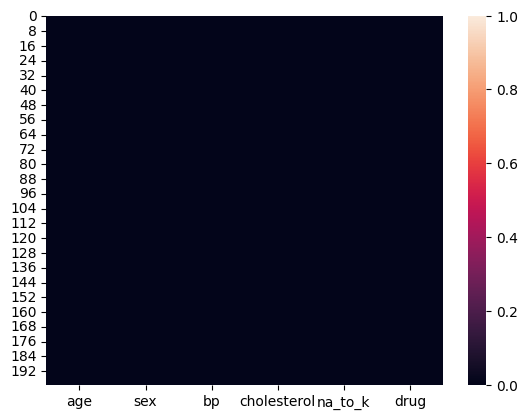

In [23]:
# analise de dados nullos - forma 3
sns.heatmap(data.isna(), vmin=0, vmax=1)

In [22]:
# (opcional) modificar os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ','_').str.replace('()','').str.replace(')','')

In [11]:
# verificar o balanceamento das classes
proportions = data['drug'].value_counts(normalize=True)

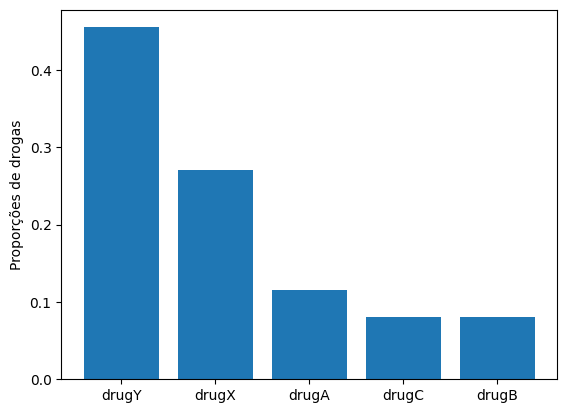

In [24]:
# outra forma de ver o balanceamento de classes
plt.bar(x=proportions.index, height=proportions.values)
plt.ylabel('Proporções de drogas')
plt.show()

In [35]:
data = data[['age','na_to_k', 'drug']]
data['drug'] = data['drug'].apply(lambda r:1 if r == 'drugC' else 0)
#y['Drug'] = y['Drug'].apply(lambda r: 1 if r == 'drugY' else 0)
data.head()

,age,na_to_k,drug
0,23,25.355,0
1,47,13.093,1
2,47,10.114,1
3,28,7.798,0
4,61,18.043,0


In [36]:
# verificação info dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      200 non-null    int64  
 1   na_to_k  200 non-null    float64
 2   drug     200 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 4.8 KB


In [37]:
# outra forma de verificar o tamanho dos dados
data.shape

(200, 3)

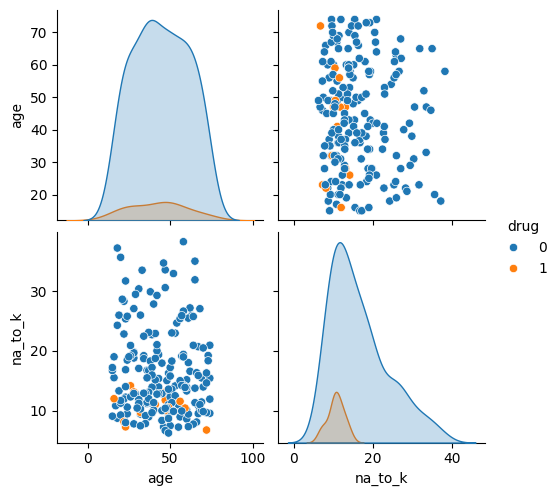

In [38]:
# analise de separabilidade linear (visual)
sns.pairplot(data, hue='drug')

In [39]:
# separando x e y
x = data.drop(columns=['drug'])
y = data[['drug']]

In [40]:
#separacao treino e teste (stratify mantem as proporcoes originais)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [41]:
props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,original,train,test
0,0.92,0.921429,0.916667
1,0.08,0.078571,0.083333


In [43]:
# criar um modelo baseline - hipotese: todas as drogas sao C
y_base = np.repeat(1, repeats=y_test.shape[0])
y_base

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
# metricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.08      1.00      0.15         5

    accuracy                           0.08        60
   macro avg       0.04      0.50      0.08        60
weighted avg       0.01      0.08      0.01        60



In [45]:
# criar um primeiro modelo de regressão logistica
rl1 = LogisticRegression(penalty=None).fit(x_train, y_train)

#fazendo previsao do teste
yhat_rl1 = rl1.predict(x_test)

#analisando metricas
print(classification_report(y_test, yhat_rl1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        55
           1       0.00      0.00      0.00         5

    accuracy                           0.92        60
   macro avg       0.46      0.50      0.48        60
weighted avg       0.84      0.92      0.88        60



In [46]:
#prevendo probabilidades
yhat_rl1_prob = rl1.predict_proba(x_test)
yhat_rl1_prob

array([[7.70014419e-01, 2.29985581e-01],
       [8.04965832e-01, 1.95034168e-01],
       [9.64652825e-01, 3.53471749e-02],
       [9.16099303e-01, 8.39006966e-02],
       [9.70572340e-01, 2.94276603e-02],
       [8.72174477e-01, 1.27825523e-01],
       [9.40381489e-01, 5.96185114e-02],
       [9.88522905e-01, 1.14770947e-02],
       [9.99144561e-01, 8.55439396e-04],
       [9.16536003e-01, 8.34639974e-02],
       [7.57646439e-01, 2.42353561e-01],
       [8.82602744e-01, 1.17397256e-01],
       [9.99554407e-01, 4.45592581e-04],
       [9.17021256e-01, 8.29787437e-02],
       [9.52732318e-01, 4.72676823e-02],
       [8.68130338e-01, 1.31869662e-01],
       [8.53056423e-01, 1.46943577e-01],
       [8.20095647e-01, 1.79904353e-01],
       [8.77735107e-01, 1.22264893e-01],
       [8.89586960e-01, 1.10413040e-01],
       [8.52247069e-01, 1.47752931e-01],
       [9.98409529e-01, 1.59047064e-03],
       [8.55871982e-01, 1.44128018e-01],
       [9.83096439e-01, 1.69035611e-02],
       [9.745432